<a href="https://colab.research.google.com/github/aydanmufti/Module-7-Assignments/blob/main/Homework_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: N-Gram Language Models with the Brown Corpus

## Due: Midnight on October 12th @ Midnight (with 2-hour grace period) and worth 85 points.

## As announced, I'll not start to count late days until midnight on 10/13 (with same grace period).

In this assignment you’ll practice **probabilistic language modeling (PLM)** by building N-Gram models that generate text. Along the way, you’ll develop the core pieces of a language model: estimating probabilities, calculating sentence likelihoods, and generating text with different strategies. The goal is to understand *how simple statistical models can produce coherent language*, and to explore refinements that make them more expressive.

### Learning Objectives

* Build and compare **unigram, bigram, and trigram** language models.
* Calculate **word and sentence probabilities** (in log-space) and use them to measure **perplexity**.
* Implement **probability-based generation** methods, including temperature-scaled sampling.
* Explore **beam search** as a way to generate higher-quality sentences.

### The four problems (high level)

1. **Problem 1 — N-Gram probabilities:**
   Build unigram, bigram, and trigram models. Compute next-word probabilities in log space to avoid numerical underflow.

2. **Problem 2 — Sentence probability & perplexity:**
   Define sentence probability, normalize for sentence length, and calculate perplexity as a measure of model quality.

3. **Problem 3 — Controlled generation:**
   Implement temperature-controlled sampling to vary randomness in generated sentences. Compare low vs. high temperatures.

4. **Problem 4 — Beam search:**
   Use perplexity to guide **beam search**, keeping track of the most likely candidate sentences at each step, and compare outputs to greedy generation.

By the end, you’ll have a working N-Gram generator capable of producing reasonable and a solid understanding of how early probabilistic approaches to NLP laid the foundation for modern deep learning methods.



### Recommended Workflow (Must Read!)

One of the most important skills in machine learning is following a **disciplined workflow** when developing complex code. The basic idea is simple:

1. **Start small:** Write and test your code using a tiny subset of your dataset.
2. **Inspect your results:** Print out and examine intermediate outputs to verify that each step behaves as expected.
3. **Iterate and tune:** Adjust hyperparameters and continue testing, gradually increasing the subset size as needed.
4. **Scale up:** Once you are confident your code is bug-free and your hyperparameters are roughly correct, run it on the **full dataset** to obtain your final results.

If you don’t have sufficient computing resources for a full run, use **as large a subset as practical** — provided you’ve begun early enough to allow for multiple iterations.


To help you follow this workflow in this homework, I’ve included a variable `num_sentences` that controls how many sentences are used from the shuffled Brown Corpus.

I recommend the following progression:

* **Step 1:** Begin with `num_sentences = 10` to debug and print out intermediate data structures (such as dictionaries) to confirm that your code works as expected.
* **Step 2:** Increase to `num_sentences = 100` to verify correctness and complete most of the homework efficiently.
* **Step 3:** Finally, if possible, run with the full dataset (`num_sentences = 57_340`), or as large a subset as your resources allow, to answer the graded questions.


There are 9 problems in this homework, each worth 9 points each, and you get 4 points free if you otherwise complete the homework.

#### Useful Imports (add more as needed)

In [1]:
import math
import re
import string
import random
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

random.seed(42)

In [2]:
'''
Reconstruct a human-readable sentence from tokens.
- Capitalize the first token (after removing <s>).
- Attach any token in string.punctuation with no preceding space.
- Attach tokens starting with an apostrophe (e.g., "'s", "'ll") with no space.
- Capitalize standalone 'i' and 'god' wherever they appear.
- If the last token is '.', '?', or '!', attach it without a space.
- Ignore boundary markers <s> and </s> if present.
Returns the sentence string and also prints it depending on flag parameter.
'''

def print_sentence(tokens, do_print=True):

    if not tokens:
        print("")
        return ""

    # Drop boundary markers if present
    start = 1 if tokens and tokens[0] == "<s>" else 0
    end = -1 if tokens and tokens[-1] == "</s>" else len(tokens)
    core = tokens[start:end]

    if not core:
        print("")
        return ""

    # Capitalize first token
    out = core[0].capitalize()

    # Process remaining tokens with spacing rules
    for i, t in enumerate(core[1:], start=1):
        is_last = (i == len(core) - 1)

        # Last-token punctuation rule
        if is_last and t in {".", "?", "!"}:
            out += t
            continue

        # General punctuation attaches with no space (e.g., ',', ':', ';', ')', etc.)
        if t in string.punctuation:
            out += t
            continue

        # Apostrophe-start tokens like "'s", "'d", "'ll"
        if t.startswith("'"):
            out += t
            continue

        # Capitalize special standalone words
        if t.lower() in {"i", "god"}:
            out += " " + t.capitalize()
            continue

        # Default: add a space before normal words
        out += " " + t

    if do_print:
        print(out)
    return out


### Read in the list of all sentences in the Brown Corpus and process using SPaCy.

In [3]:
# Must do this the first time to get the Natural Language ToolKit

!pip install nltk

In [4]:
import nltk
from nltk.corpus import brown
import spacy

nltk.download('brown')

# Get all Brown corpus sentences as raw text
# Brown is organized into categories, we flatten it into one list of sentences and shuffle
# so we can create a shorter list for testing

brown_texts = [" ".join(sent) for sent in brown.sents()]

random.shuffle(brown_texts)

# Brown has 57_340 sentences, set `num_sentences` to 1000 or smaller for testing

# num_sentences = 57_340
# num_sentences = 10                           # <<<<<=====    Here is where you can change the size of the dataset
num_sentences = 100

brown_texts = brown_texts[:num_sentences]

# Load spaCy English pipeline
nlp = spacy.load("en_core_web_sm")

# Process with spaCy: tokenize + sentencize
docs = list(nlp.pipe(brown_texts, disable=["ner", "tagger", "parser"]))

# Each doc is one sentence; extract tokens and add beginning and ending tokens <s> ... </s>
tokenized_sentences = [ ['<s>'] + [token.text.lower() for token in doc if not token.is_space] + ['</s>'] for doc in docs ]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


#### If you have trouble downloading this...


I have uploaded a file `brown_sentences.txt` to a Google Drive folder which anyone with the link can read, just
uncomment the code in the next cell and run it:

In [5]:
'''
import re, requests, random, spacy

# Paste the shared Drive link (no need to change anything else)
link = "https://drive.google.com/file/d/1f_BkNDF0ny11Tn4D4jsOoXhgPSUCHKlf/view?usp=drive_link"

# --- Convert to direct download URL ---
def get_direct_download_url(link):
    match = re.search(r"/d/([a-zA-Z0-9_-]+)", link) or re.search(r"id=([a-zA-Z0-9_-]+)", link)
    if not match:
        raise ValueError("Could not extract file ID from the link.")
    file_id = match.group(1)
    return f"https://drive.google.com/uc?export=download&id={file_id}"

url = get_direct_download_url(link)

# --- Download and prepare the text ---
response = requests.get(url)
lines = response.text.strip().split("\n")

random.shuffle(lines)


# Etc as before
'''

'\nimport re, requests, random, spacy\n\n# Paste the shared Drive link (no need to change anything else)\nlink = "https://drive.google.com/file/d/1f_BkNDF0ny11Tn4D4jsOoXhgPSUCHKlf/view?usp=drive_link"\n\n# --- Convert to direct download URL ---\ndef get_direct_download_url(link):\n    match = re.search(r"/d/([a-zA-Z0-9_-]+)", link) or re.search(r"id=([a-zA-Z0-9_-]+)", link)\n    if not match:\n        raise ValueError("Could not extract file ID from the link.")\n    file_id = match.group(1)\n    return f"https://drive.google.com/uc?export=download&id={file_id}"\n\nurl = get_direct_download_url(link)\n\n# --- Download and prepare the text ---\nresponse = requests.get(url)\nlines = response.text.strip().split("\n")\n\nrandom.shuffle(lines)\n\n\n# Etc as before\n'

In [6]:
print("Number of sentences:", len(tokenized_sentences))
print("First sentence:      ",end='')
print_sentence(tokenized_sentences[0])
print("Tokenized sentence: ",end='')
print(tokenized_sentences[0])

Number of sentences: 100
First sentence:      He let her tell him all about the church.
Tokenized sentence: ['<s>', 'he', 'let', 'her', 'tell', 'him', 'all', 'about', 'the', 'church', '.', '</s>']


### A Little EDA....

In [7]:
# Flatten tokens (exclude spaces)
all_tokens = [tok.text.lower() for sent in docs for tok in sent if not tok.is_space]

# Define "word": alphabetic, or alphabetic after removing internal apostrophes
def is_word(tok):
    s = tok.text
    return s.isalpha() or s.replace("'", "").isalpha()

# Extract words using the definition above
words = [
    tok.text.lower()
    for sent in docs
    for tok in sent
    if not tok.is_space and is_word(tok)
]

# Counts
num_chars = sum(len(s) for s in brown_texts)   # or len(text) if you started from one big text
num_tokens = len(all_tokens)
num_unique_tokens = len(set(all_tokens))
num_sentences = len(docs)
num_words = len(words)
num_unique_words = len(set(words))

print(f"Total number of characters in the text: {num_chars:,}")
print(f"Total number of tokens:    {num_tokens:,}")
print(f"Number of unique tokens:   {num_unique_tokens:,}")
print(f"Total number of sentences: {num_sentences:,}")
print(f"Total number of words:     {num_words:,}")
print(f"Number of unique words:    {num_unique_words:,}")

# Frequencies
word_counts = Counter(words)
most_common_words = word_counts.most_common()

# Top 10
print("\nTop 10 words:")
for token, freq in most_common_words[:10]:
    print(f"{token:<15}: {freq:,}")

# Bottom 10
print("\nBottom 10 words:")
for token, freq in most_common_words[-10:]:
    print(f"{token:<15}: {freq:,}")

Total number of characters in the text: 11,495
Total number of tokens:    2,187
Number of unique tokens:   990
Total number of sentences: 100
Total number of words:     1,860
Number of unique words:    950

Top 10 words:
the            : 138
of             : 83
and            : 57
to             : 46
a              : 43
in             : 34
that           : 21
was            : 20
by             : 17
is             : 17

Bottom 10 words:
overseas       : 1
government     : 1
through        : 1
organizations  : 1
help           : 1
foreign        : 1
countries      : 1
needs          : 1
skilled        : 1
manpower       : 1


### Digression: Zipf's Law

Zipf's Law is an empirical regularity of natural language:  
if you rank words by their frequency in a corpus, the frequency \( f(r) \) of the word at rank \( r \) is approximately inversely proportional to its rank:

$$
f(r) \propto \frac{1}{r^k}
$$

where $ r = 1, 2, 3, \dots $ is the rank of a word (1 = most frequent), and $ k \approx 1 $.  

- The most common words (e.g., *the*, *of*, *and*) occur very often.  
- A handful of mid-ranked words occur moderately often.  
- The vast majority of words occur rarely.  

On a **log–log plot** of frequency vs. rank, this relationship appears as a straight line with slope \(-k\).  
For natural language, empirical studies show that $k \approx 1$, which is why we plot below a reference line with slope $-1$ to compare against real corpus data.


**Why this matters:** Because most words are rare, language models must use techniques like **smoothing, subword modeling, or embeddings** to handle sparsity and represent meaning effectively.  


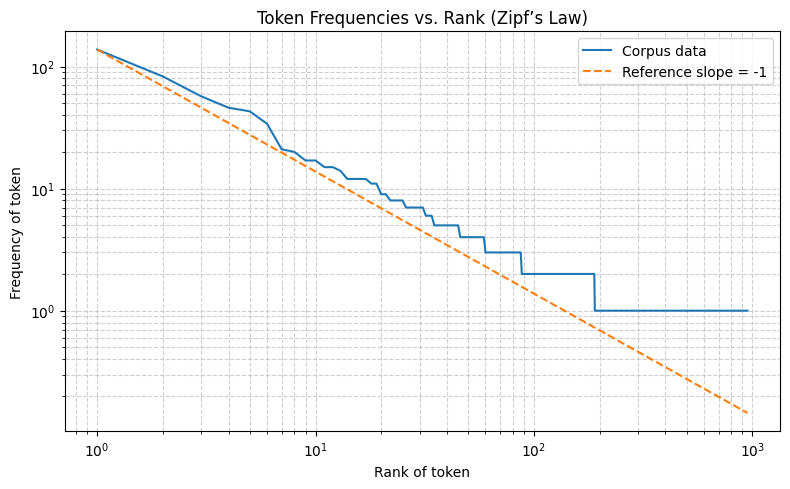

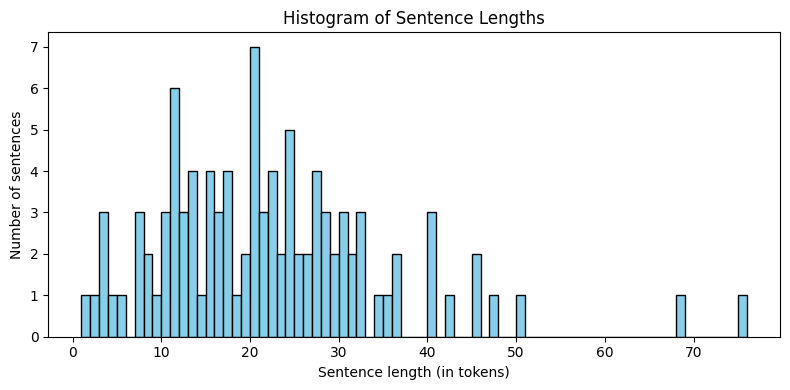

Average sentence length: 21.87 tokens
Max sentence length:     75 tokens


In [8]:
# Frequencies sorted by rank
freqs = np.array([freq for token, freq in word_counts.most_common()])
ranks = np.arange(1, len(freqs) + 1)

plt.figure(figsize=(8, 5))
plt.plot(ranks, freqs, label="Corpus data")

# Reference line: slope = -1 (Zipf’s law)
# Match scale by anchoring at the first frequency
ref_line = freqs[0] / ranks
plt.plot(ranks, ref_line, "--", label="Reference slope = -1")

plt.xscale("log")
plt.yscale("log")
plt.title("Token Frequencies vs. Rank (Zipf’s Law)")
plt.xlabel("Rank of token")
plt.ylabel("Frequency of token")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Compute sentence lengths from spaCy docs
sentence_lengths = [len([tok for tok in sent if not tok.is_space]) for sent in docs]

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(
    sentence_lengths,
    bins=range(1, max(sentence_lengths) + 2),
    color="skyblue",
    edgecolor="black"
)
plt.title("Histogram of Sentence Lengths")
plt.xlabel("Sentence length (in tokens)")
plt.ylabel("Number of sentences")
plt.tight_layout()
plt.show()

print(f"Average sentence length: {sum(sentence_lengths)/len(sentence_lengths):.2f} tokens")
print(f"Max sentence length:     {max(sentence_lengths)} tokens")

## Problem One — Build the PLM (bigrams & trigrams)

For this problem, you must adapt (mostly cut-and-paste) the code from this week’s Coding Notebook to the new dataset. You are using a trigram model as well as bigrams but your professor has written code that should mostly work for any N.

We provide a pre-processed dataset above, with sentences already tokenized and enclosed in the boundary tokens `<s>` and `</s>`.

**Set `num_sentences=10` to start!**

**ToDo:**

**A.** Build N-grams for N = 2, 3

- Compute all bigrams and trigrams over the tokenized sentences (boundary tokens included).

**B.** Create a dictionary mapping left-contexts to next-word lists

- For each N, map each context (length N−1) to a list of next tokens (allow duplicates so frequency = count).

**C.** Convert to (log) probability distributions

- Turn each context’s next-word list into a distribution of log-probabilities (see **Appendix Two**).

**D.** Create the Probability Language Model (PLM)

- Create a dictionary `get_next_word` with:

    - Key: left context (tuple of 1 token for bigrams; 2 tokens for trigrams).
    
    - Values: nested dictionary mapping next tokens to log-probabilities `{next_token: log_prob, ...}`.

- Create a **single dictionary** (since bigrams and trigrams have a left context of different lengths, and they won't get confused in the dictionary).


**E.** Set the variable `num_sentences = 10` and do a sanity check by displaying the distribution for the bigram contexts e.g., `('<s>',)` and `('the',)` and a trigram context `('<s>','the')`. If for some reason these are not present, increase the number of sentences slightly.  

**F.**  Generate 5 next words for each of the 3 examples in the previous part.

**Then answer the graded questions.**

In [9]:
# Your code here (add as many cells as you need)
# A. Build N-grams for N = 2, 3

# Take a sentence and return a list of all N-grams for a given N
def get_ngrams(sent, N):
    return [tuple(sent[k:k+N]) for k in range(len(sent) - N + 1)]

print("First sentence:", tokenized_sentences[0])
print("\nBigrams:")
print(get_ngrams(tokenized_sentences[0], 2))
print("\nTrigrams:")
print(get_ngrams(tokenized_sentences[0], 3))

First sentence: ['<s>', 'he', 'let', 'her', 'tell', 'him', 'all', 'about', 'the', 'church', '.', '</s>']

Bigrams:
[('<s>', 'he'), ('he', 'let'), ('let', 'her'), ('her', 'tell'), ('tell', 'him'), ('him', 'all'), ('all', 'about'), ('about', 'the'), ('the', 'church'), ('church', '.'), ('.', '</s>')]

Trigrams:
[('<s>', 'he', 'let'), ('he', 'let', 'her'), ('let', 'her', 'tell'), ('her', 'tell', 'him'), ('tell', 'him', 'all'), ('him', 'all', 'about'), ('all', 'about', 'the'), ('about', 'the', 'church'), ('the', 'church', '.'), ('church', '.', '</s>')]


In [10]:
# Create lists of all bigrams and trigrams
bigrams = []
for sent in tokenized_sentences:
    bigrams += get_ngrams(sent, 2)

trigrams = []
for sent in tokenized_sentences:
    trigrams += get_ngrams(sent, 3)

print(f"There are {len(bigrams)} total bigrams.")
print(f"There are {len(set(bigrams))} unique bigrams.")
print(f"\nThere are {len(trigrams)} total trigrams.")
print(f"There are {len(set(trigrams))} unique trigrams.")

There are 2287 total bigrams.
There are 1953 unique bigrams.

There are 2187 total trigrams.
There are 2158 unique trigrams.


In [11]:
# B. Create a dictionary mapping left-contexts to next-word lists
# Take a list of N-grams and create a next-word dictionary
def get_next_word_dict(ngrams):
    dict = {}
    for ng in ngrams:
        lcontext = ng[:-1]
        next_word = ng[-1]
        dict[lcontext] = dict.get(lcontext, []) + [next_word]
    return dict

# Create next-word dictionaries
bigram_next_word_dict = get_next_word_dict(bigrams)
trigram_next_word_dict = get_next_word_dict(trigrams)

print(f"Number of unique bigram contexts: {len(bigram_next_word_dict)}")
print(f"Number of unique trigram contexts: {len(trigram_next_word_dict)}")

Number of unique bigram contexts: 991
Number of unique trigram contexts: 1947


In [12]:
# C. Convert to log probability distributions
# Turn list of tokens into a log-probability distribution dictionary
def tokens2log_probs(ws):
    k = len(ws)
    return {w: math.log(f/k) for (w, f) in Counter(ws).items()}

test_tokens = ['and', 'then', 'and', 'when']
print("Test tokens:", test_tokens)
print("Log probabilities:", tokens2log_probs(test_tokens))

Test tokens: ['and', 'then', 'and', 'when']
Log probabilities: {'and': -0.6931471805599453, 'then': -1.3862943611198906, 'when': -1.3862943611198906}


In [13]:
# D. Create the Probability Language Model (PLM)
# Convert a next-word dictionary from contexts into a PLM = a dictionary from left-contexts to a probability distribution of next words
def get_PLM(D):
    return {lcontext: tokens2log_probs(next_words) for (lcontext, next_words) in D.items()}

# Create PLMs for bigrams and trigrams
bigram_plm = get_PLM(bigram_next_word_dict)
trigram_plm = get_PLM(trigram_next_word_dict)

# Combine into single dictionary (since contexts are different lengths, no collision)
plm = {**bigram_plm, **trigram_plm}

print(f"Total number of contexts in combined PLM: {len(plm)}")
print(f"Bigram contexts: {len(bigram_plm)}")
print(f"Trigram contexts: {len(trigram_plm)}")

Total number of contexts in combined PLM: 2938
Bigram contexts: 991
Trigram contexts: 1947


In [14]:
# E. Sanity check - display distributions for specific contexts

# Check if contexts exist
if ('<s>',) in plm:
    print("Bigram context ('<s>',):")
    print(plm[('<s>',)])
    print()
else:
    print("Context ('<s>',) not found")

if ('the',) in plm:
    print("Bigram context ('the',):")
    print(plm[('the',)])
    print()
else:
    print("Context ('the',) not found")

if ('<s>', 'the') in plm:
    print("Trigram context ('<s>', 'the'):")
    print(plm[('<s>', 'the')])
    print()
else:
    print("Context ('<s>', 'the') not found - possibly might need more sentences!!!!!!")

Bigram context ('<s>',):
{'he': -2.8134107167600364, 'china': -4.605170185988091, 'finally': -4.605170185988091, 'a': -3.912023005428146, 'during': -4.605170185988091, 'it': -3.2188758248682006, 'just': -4.605170185988091, 'water': -4.605170185988091, 'cholesterol': -4.605170185988091, '`': -2.995732273553991, 'there': -3.506557897319982, 'acquire': -4.605170185988091, 'in': -3.506557897319982, 'theories': -4.605170185988091, 'all': -4.605170185988091, 'we': -4.605170185988091, 'to': -3.912023005428146, 'if': -4.605170185988091, 'little': -4.605170185988091, 'the': -2.3025850929940455, 'after': -3.912023005428146, 'that': -4.605170185988091, 'mrs.': -4.605170185988091, 'one': -3.912023005428146, 'two': -4.605170185988091, 'mr.': -4.605170185988091, '(': -3.912023005428146, 'nor': -4.605170185988091, 'then': -4.605170185988091, '13': -4.605170185988091, 'fromm': -4.605170185988091, 'but': -4.605170185988091, 'ambiguity': -4.605170185988091, 'as': -4.605170185988091, 'i': -3.506557897319

In [15]:
# F. Generate 5 next words for each of the 3 contexts
# Get next word by sampling from the probability distribution.
# Uses log probabilities, so convert back to regular probabilities for sampling
def get_next_word(lcontext, plm):
    next_word_dist = plm[lcontext]

    # Convert log probs back to regular probs
    tokens = list(next_word_dist.keys())
    log_probs = list(next_word_dist.values())

    # Convert to regular probabilities
    max_log_prob = max(log_probs)
    probs = [math.exp(lp - max_log_prob) for lp in log_probs]

    # Normalize
    total = sum(probs)
    probs = [p/total for p in probs]

    return random.choices(tokens, weights=probs)[0]

# Generate 5 next words for each context
contexts_to_test = [('<s>',), ('the',), ('<s>', 'the')]

for context in contexts_to_test:
    if context in plm:
        print(f"\nContext {context}:")
        next_words = [get_next_word(context, plm) for _ in range(5)]
        print(f"5 generated next words: {next_words}")
    else:
        print(f"\nContext {context} not found in PLM")


Context ('<s>',):
5 generated next words: ['the', 'two', 'china', 'while', 'one']

Context ('the',):
5 generated next words: ['degree', 'missile', 'rev.', 'early', 'united']

Context ('<s>', 'the'):
5 generated next words: ['genuinely', 'velvet', 'belgians', 'velvet', 'president']


### Graded Question:

In the next cell, set `a1` to the list of 5 next words for the trigram context `('<s>','the')` (unlikely, but you may have to adjust `num_sentences` as indicated).

In [16]:
# Your answer here

a1 = [get_next_word(('<s>', 'the'), plm) for _ in range(5)]

In [17]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1 in this problem

print(f'a1 = {a1}')


a1 = ['latter', 'church', 'favorite', 'grateful', 'president']


## Problem Two: Generating Sentences with Backoff and Temperature


The algorithm for generating sentences from a N-Gram PLM is simple: look at the last $N-1$ tokens of the sentence and use the probability distribution of next words to select the continuation word; stop when you generate `'</s>'`.


For **bigrams**, this works well: Every token in the text is followed by another token (because `</s>` ends every sentence).

However there are two problems when using N-grams for $N>2$:

**1. Cold Start (not enough left-context):**  You don't have enough left context in the beginning, so you start with what you have until you have enough left context.   For example, with trigrams:

                                          Find next word using:
        Step 1:    <s> ?                      bigrams
         context:  ---
        Step 2:    <s> One ?                  trigrams
         context:  ------
        Step 3:    <s> One ish ?             continue on with trigrams
         context:      ---------


**2. Sparsity (not enough N-grams):** For bigrams we always have a continuation for the left context (1 token). However, it is possible for $N>2$ that there is no N-gram which gives you a choice of next words, for example, suppose your sentence so far is

            "One fish dish ..."

and there is no trigram in the form `("fish", "dish", ...)`. In this case we use the **backoff** strategy: if there is no trigram left-context `("fish", "dish")`,
cut out one token and use the (safe) bigram strategy with left context `("dish",)`.  In general, for any $N$,
if $N$ does not provide a next word, try $N-1$, $N-2$ etc. until one is found (in the worse case,
for $N=1$, you'll just select a likely word without any left-context, but note that with boundary tokens, you'll
always have a bigram).


**ToDo:**

- Adapt the code for generating sentences from the Coding Video to perform the backoff strategy just described, and using your code from Problem One.
- Make sure you convert the log probabilities **back into non-log probabilities before you use them as weights in in `np.choice(..., p=weights)`**.
- Perform 3 experiments with temperature set at 0.2, 1.0, and 5.0 **with the full dataset if possible**:
    - Generate 10 sentences for each temperature, print them out using `print_sentence` and observe whatever differences you can.
- Answer the graded questions.

In [27]:
# Your code here (add as many cells as you need)
# Function to get next word with backoff strategy and temperature

# Get next word using backoff strategy and temperature.
# - lcontext: tuple of tokens (left context)
# - plm: probability language model dictionary
# - temp: temperature for sampling

# If lcontext not found, back off to shorter context.

def get_next_word_backoff(lcontext, plm, temp=1.0):
    # Try current context
    current_context = lcontext

    # Back off until we find a context that exists in the PLM
    while current_context not in plm and len(current_context) > 0:
        current_context = current_context[1:]  # Remove leftmost token

    # If still not found, fall back to empty context (shouldn't happen with proper PLM)
    if current_context not in plm:
        # This shouldn't happen, but as a safety, pick a random context
        current_context = random.choice(list(plm.keys()))

    # Get the log probability distribution for next words
    next_word_log_dist = plm[current_context]

    # Convert to lists for processing
    tokens = list(next_word_log_dist.keys())
    log_probs = list(next_word_log_dist.values())

    # Convert log probs to regular probs with numerical stability
    max_log_prob = max(log_probs)
    probs = [math.exp(lp - max_log_prob) for lp in log_probs]

    # Apply temperature
    if temp != 1.0:
        probs = np.array(probs, dtype=np.float64)
        probs = np.clip(probs, 1e-12, 1.0)  # Avoid log(0)
        scaled = np.exp(np.log(probs) / temp)
        probs = (scaled / np.sum(scaled)).tolist()
    else:
        # Just normalize without temperature
        total = sum(probs)
        probs = [p/total for p in probs]

    # Sample next word
    return random.choices(tokens, weights=probs)[0]

# Test the function
test_context = ('<s>', 'the')
print(f"Testing with context {test_context}:")
for i in range(5):
    next_word = get_next_word_backoff(test_context, plm, temp=1.0)
    print(f"  Next word {i+1}: {next_word}")

Testing with context ('<s>', 'the'):
  Next word 1: velvet
  Next word 2: latter
  Next word 3: belgians
  Next word 4: president
  Next word 5: belgians


In [19]:
# Function to generate a complete sentence with backoff

# Generate a sentence using N-gram model with backoff and temperature.
# - plm: probability language model dictionary
# - N: maximum N-gram order
# - temp: temperature for sampling
# - max_len: maximum sentence length to prevent infinite loops
def get_sentence_backoff(plm, N=3, temp=1.0, max_len=100):
    sentence = ['<s>']

    while sentence[-1] != '</s>' and len(sentence) < max_len:
        # Determine left context size based on current sentence length
        # Start with smaller context if we don't have enough tokens yet
        context_size = min(N - 1, len(sentence))
        lcontext = tuple(sentence[-context_size:]) if context_size > 0 else tuple()

        # Get next word with backoff
        next_word = get_next_word_backoff(lcontext, plm, temp=temp)
        sentence.append(next_word)

    return sentence

# Test sentence generation
print("Testing sentence generation with trigram model (N=3):\n")
for i in range(3):
    sent = get_sentence_backoff(plm, N=3, temp=1.0)
    print(f"Sentence {i+1}:")
    print_sentence(sent)
    print()

Testing sentence generation with trigram model (N=3):

Sentence 1:
To step up the denomination's program, the rev. mr. brandt suggested the vision of 8,000 new assemblies of God churches in the way to dress than college students.

Sentence 2:
One bronchial arteriolar- pulmonary arteriolar anastomosis was noted at the far end and in another by the united states, as pentagon mutterers labeled it, apparently was a post of honor, held inviolate for him;;

Sentence 3:
`` hold- back'', watching to see to the congress the establishment of a married couple may reflect an abiding belief that the communion between husband and wife is such that their actions are not always to be similar in potency, composition and physical properties.



In [26]:
# Function to generate a complete sentence with backoff
# Generate a sentence using N-gram model with backoff and temperature.
#     - plm: probability language model dictionary
#     - N: maximum N-gram order (e.g., 3 for trigrams)
#     - temp: temperature for sampling
#     - max_len: maximum sentence length to prevent infinite loops
def get_sentence_backoff(plm, N=3, temp=1.0, max_len=100):
    sentence = ['<s>']

    while sentence[-1] != '</s>' and len(sentence) < max_len:
        # Determine left context size based on current sentence length
        # Start with smaller context if we don't have enough tokens yet
        context_size = min(N - 1, len(sentence))
        lcontext = tuple(sentence[-context_size:]) if context_size > 0 else tuple()

        # Get next word with backoff
        next_word = get_next_word_backoff(lcontext, plm, temp=temp)
        sentence.append(next_word)

    return sentence

# Test sentence generation
print("Testing sentence generation with trigram model (N=3):\n")
for i in range(3):
    sent = get_sentence_backoff(plm, N=3, temp=1.0)
    print(f"Sentence {i+1}:")
    print_sentence(sent)
    print()

Testing sentence generation with trigram model (N=3):

Sentence 1:
He was not a new experience to ekstrohm.

Sentence 2:
Acquire secret processes, technical data, inventions, patent applications, patents, licenses, land and interests in land( including water rights), plants and facilities, and cotton and palm oil.

Sentence 3:
Finally, it is, they are in having the world.



In [21]:
# Experiment 1: Temperature = 0.2 (Low - more focused/deterministic)

print("EXPERIMENT 1: Temperature = 0.2 (Low - focused, deterministic)")
print("-" * 70)
print()

temperature = 0.2
sentences_temp_02 = []

for i in range(10):
    sent = get_sentence_backoff(plm, N=3, temp=temperature)
    sentences_temp_02.append(sent)
    print(f"Sentence {i+1}:")
    print_sentence(sent)
    print()

EXPERIMENT 1: Temperature = 0.2 (Low - focused, deterministic)
----------------------------------------------------------------------

Sentence 1:
The grateful way she looked at morgan made him ashamed of himself.

Sentence 2:
The belgians were interested primarily in the economic development of children, the hills roll softly.

Sentence 3:
The church today stands in the cafeteria, the new country the electoral process is considered as a night club monologist, proved himself very much at home in musical comedy.

Sentence 4:
The most prominent magazine illustrators in america;;

Sentence 5:
`` we must keep the bloodstream of new jersey in the early 1920s following adoption of the way of unity.

Sentence 6:
The favorite excuse of those who have now recanted their approval of communism is that they did not know how things would develop.

Sentence 7:
The grateful way she looked at morgan made him ashamed of himself.

Sentence 8:
The belgians were interested primarily in the closet.

Senten

In [22]:
# Experiment 2: Temperature = 1.0 (Medium - balanced)

print("EXPERIMENT 2: Temperature = 1.0 (Balanced)")
print("-" * 70)
print()

temperature = 1.0
sentences_temp_10 = []

for i in range(10):
    sent = get_sentence_backoff(plm, N=3, temp=temperature)
    sentences_temp_10.append(sent)
    print(f"Sentence {i+1}:")
    print_sentence(sent)
    print()

EXPERIMENT 2: Temperature = 1.0 (Balanced)
----------------------------------------------------------------------

Sentence 1:
Andrei remembered a bathyran meeting long ago.

Sentence 2:
Enthusiastically, americans have swept subliterary and bogus materials like paul bunyan tales, abe lincoln anecdotes and labor union songs up as true products of our american oral tradition.

Sentence 3:
Or who undertook to set records for remaining erect on a dance floor, with or without a partner;;

Sentence 4:
One must first detect a fleeting mobile or moving target, compute ballistics for the social development of children, the teacher can find a great deal of information concerning types of social behavior normally displayed by children at various age levels.

Sentence 5:
Water rationing will be to remove as far as possible whatever in the philippines have demonstrated that transitional societies can work toward balanced national development.

Sentence 6:
We were told that to the kitchen.

Sentenc

In [23]:
# Experiment 3: Temperature = 5.0 (High - more random/creative)

print("EXPERIMENT 3: Temperature = 5.0 (High - random, creative)")
print("-" * 70)
print()

temperature = 5.0
sentences_temp_50 = []

for i in range(10):
    sent = get_sentence_backoff(plm, N=3, temp=temperature)
    sentences_temp_50.append(sent)
    print(f"Sentence {i+1}:")
    print_sentence(sent)
    print()

EXPERIMENT 3: Temperature = 5.0 (High - random, creative)
----------------------------------------------------------------------

Sentence 1:
If you walk into the ferry.

Sentence 2:
Calloused fingers, caressed only by the united states, its officers, agents, or the comptroller general of the human than any other person against the target, compute ballistics for the social development of children, the stem and the bluebush, has been designated a cavaliere of the sorrentine peninsula, had swayed excitedly beneath puckered chins where tiny black hairs sprouted, never to be tweezed away.

Sentence 3:
He saw the suitcase, which is rich in copper, tin, cobalt, manganese, zinc, and cotton and palm oil.

Sentence 4:
Mr. mccormack.

Sentence 5:
Andrei remembered a bathyran meeting long ago.

Sentence 6:
Finally, it shall be an absolute bar to recovery by any other presently known species.

Sentence 7:
Acquire secret processes, technical data, inventions, patent applications, patents, licenses,

In [32]:
# Collect all sentences from all experiments
all_sentences = sentences_temp_02 + sentences_temp_10 + sentences_temp_50

# Print all sentences with indices for selection
print("All generated sentences:")
print()
for idx, sent in enumerate(all_sentences):
    print(f"[{idx}] ", end="")
    print_sentence(sent)
    print()

best_sentence_index = 0

a2a = print_sentence(all_sentences[best_sentence_index], do_print=False)
print(f"\nSelected most realistic sentence (index {best_sentence_index}):")
print(f"a2a = '{a2a}'")

All generated sentences:

[0] The grateful way she looked at morgan made him ashamed of himself.

[1] The belgians were interested primarily in the economic development of children, the hills roll softly.

[2] The church today stands in the cafeteria, the new country the electoral process is considered as a night club monologist, proved himself very much at home in musical comedy.

[3] The most prominent magazine illustrators in america;;

[4] `` we must keep the bloodstream of new jersey in the early 1920s following adoption of the way of unity.

[5] The favorite excuse of those who have now recanted their approval of communism is that they did not know how things would develop.

[6] The grateful way she looked at morgan made him ashamed of himself.

[7] The belgians were interested primarily in the closet.

[8] The most active preparations obtained by these two groups of investigators appear to be similar in potency, composition and physical properties.

[9] The belgians were interes

### Graded Questions:

#### Part 2A: In the next cell, set `a2a` to the *most realistic sentence* generated (your call!). Use `print_sentence(..., do_print=False)`.

In [33]:
# Your answer here
a2a = print_sentence(all_sentences[best_sentence_index], do_print=False)

In [34]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a2a in this problem

print(f'a2a = {a2a}')


a2a = The grateful way she looked at morgan made him ashamed of himself.


#### Part 2B:  Describe in a few sentences what you observed with the different temperature settings (and try more if you wish!). Which seemed to produce the most realistic sentences?

Your answer here:


The Temperature 0.2 (low) model produced more repetitive and deterministic outputs. Several sentences were duplicated (for example: "The grateful way she looked at morgan made him ashamed of himself" and "The belgians were interested primarily in the closet" appeared multiple times). The sentences started coherent but often had more predictable and less diverse word choices.
The Temperature 1.0 (balanced) setting produced the most realistic and varied sentences. The outputs were grammatically correct, semantically coherent, and showed good diversity without being too random. Sentences like "Andrei remembered a bathyran meeting long ago" and "The grateful way she looked at morgan made him ashamed of himself" are completely natural. The only critique is that I am not sure what a "bathyran meeting" is and the incorrect capitalization of "morgan."
The Temperature 5.0 (high) model generated more creative but often incoherent sentences. These outputs were longer, more chaotic, and contained unusual word combinations and run-on structures. While diverse, they often lacked logical flow and semantic coherence (for example: the very long sentence about "calloused fingers" and "puckered chins").

## Problem Three:  Measuring the Quality of Sentences:  Average Log Probability and Perplexity

The probabilities involved when we start to calculate the probability of longer token sequences are extremely small, and underflow is common
for a large corpus. Therefore we calculate all probabilities in **log space** (see **Appendix Two** for an explanation).

Basically, the quality metric for generated sentences is likelihood: If a sentence is more probable, it is better.
However, this metric is biased towards short sentences, since we multiply the probabilities of each word,
and long sentences end up being very unlikely. But natural language does not behave this way!

Therefore, we will remove the length from the calculation using the following measures:

**Average of Log Probabilities (ALP)** is a length-agnostic measure of sentence probability. For trigrams:

Let the tokenized sentence be $[t_1,\ldots,t_n]$ with $t_1$ = `<s>` and $t_n$ = `</s>`.


$$
\text{ALP}([t_1, t_2, \dots, t_n])
\ =\ \frac{\log P(t_2 \mid t_1) + \log P(t_3 \mid t_1, t_2) + \dots + \log P(t_n \mid t_{n-2}, t_{n-1})}{n-1}
$$

**Notes:**
- We don't include the first token because it is always present and hence not predicted; think of
it as a prompt which gets the sentence going!
- To account for backoff, simply use the log probability of the bigram in those cases instead of the trigram.
- ALP is in $(-\infty \ldots 0.0]$ and larger is better.  It grows more negative as the model performs worse.


**Perplexity** is the most common metric in NLP: it rescales the ALP into a more intuitive, positive scale:

> Perplexity = np.exp( - ALP ).     

Perplexities are $\ge 1.0$ and smaller is better.   A larger perplexity means the model is “more perplexed,” i.e., on average it is choosing among more equally likely alternatives.

Because the exponential is monotonic, minimizing perplexity is exactly the same as maximizing average log probability—so either metric may be used for ranking models, but perplexity is more commonly used by the NLP community.

### Before You Start

You can compute ALP during generation by carrying **state** along with the partial sentence.
Instead of storing:

> tokens_so_far = [ `<s>`, $t_2$, $t_3$, … ]

store a **pair**:

> ( tokens_so_far, sum_log_probs)

where

* **sum_log_probs** = $( \log P(t_2\mid t_1) + \log P(t_3\mid t_1,t_2) + \cdots )$

In the case that backoff was used to generate some $t_k$, you just use $\log P(t_{k}\mid t_{k-1})$

Then your loop is:

1. Start with tokens = `['<s>']` and `sum_log_probs = 0.0`.
2. Get the left context (trigram preferred; back off to bigram if needed).
3. **Sample** the next token using temperature, but **score** with the model’s **true** log-prob for that token (un-tempered): update `sum_log_probs += log P(next|context)`.
4. Append the token; if it is `</s>`, stop, else repeat froms step 2.
5. Calculate the perplexity of the completed sentence:
- Divide the running sum of log probabilities by `len(tokens)-1` to get the final ALP.
- Calculate `PP = np.exp(-ALP)` and return the pair `( completed-list-of-tokens, PP)` as the generated sentence.



### To Do

* Modify your `get_next_word` and sentence generator method to maintain `(tokens, sum_log)` as above and return `(tokens, Perplexity)`.
- Perform 3 experiments with temperature set at 0.2, 1.0, and 5.0 **with the full dataset if possible**:
    - Generate 10 sentences for each temperature, print them out using `print_sentence` and observe whatever differences you can, comparing them with the perplexity.
* Answer the graded questions.


In [52]:
# Your code here: add as many cells as you wish
# Modified function to get next word and return its log probability
# Get next word using backoff strategy and temperature.
# Returns: (next_word, log_prob, context_used)
# - next_word: the sampled token
# - log_prob: the TRUE log probability from the model (not temperature-adjusted)
# - context_used: the actual context used (after backoff if needed)

def get_next_word_with_log_prob(lcontext, plm, temp=1.0):
    # Try current context, back off if needed
    current_context = lcontext

    while current_context not in plm and len(current_context) > 0:
        current_context = current_context[1:]  # Remove leftmost token

    if current_context not in plm:
        # Safety fallback
        current_context = random.choice(list(plm.keys()))

    # Get the log probability distribution for next words
    next_word_log_dist = plm[current_context]

    # Convert to lists
    tokens = list(next_word_log_dist.keys())
    log_probs = list(next_word_log_dist.values())

    # Convert log probs to regular probs with numerical stability
    max_log_prob = max(log_probs)
    probs = [math.exp(lp - max_log_prob) for lp in log_probs]

    # Apply temperature for sampling only
    if temp != 1.0:
        probs_array = np.array(probs, dtype=np.float64)
        probs_array = np.clip(probs_array, 1e-12, 1.0)
        scaled = np.exp(np.log(probs_array) / temp)
        sampling_probs = (scaled / np.sum(scaled)).tolist()
    else:
        # Just normalize
        total = sum(probs)
        sampling_probs = [p/total for p in probs]

    # Sample next word using temperature-adjusted probabilities
    next_word = random.choices(tokens, weights=sampling_probs)[0]

    # Get the true log probability (not temperature-adjusted) for scoring
    word_index = tokens.index(next_word)
    true_log_prob = log_probs[word_index]

    return next_word, true_log_prob, current_context

# Test
test_context = ('<s>', 'the')
print(f"Testing with context {test_context}:\n")
for i in range(5):
    word, log_p, ctx = get_next_word_with_log_prob(test_context, plm, temp=1.0)
    print(f"  Word: {word:15s} | Log P: {log_p:.4f} | Context used: {ctx}")


Testing with context ('<s>', 'the'):

  Word: favorite        | Log P: -2.3026 | Context used: ('<s>', 'the')
  Word: velvet          | Log P: -2.3026 | Context used: ('<s>', 'the')
  Word: president       | Log P: -2.3026 | Context used: ('<s>', 'the')
  Word: velvet          | Log P: -2.3026 | Context used: ('<s>', 'the')
  Word: belgians        | Log P: -2.3026 | Context used: ('<s>', 'the')


In [53]:
# Modified sentence generator that tracks perplexity

# Generate a sentence using N-gram model with backoff and temperature.
# Returns: (tokens, perplexity)
# - tokens: list of tokens including <s> and </s>
# - perplexity: the perplexity of the generated sentence
def get_sentence_with_perplexity(plm, N=3, temp=1.0, max_len=100):
    tokens = ['<s>']
    sum_log_probs = 0.0

    while tokens[-1] != '</s>' and len(tokens) < max_len:
        # Determine left context size based on current sentence length
        context_size = min(N - 1, len(tokens))
        lcontext = tuple(tokens[-context_size:]) if context_size > 0 else tuple()

        # Get next word with its true log probability
        next_word, true_log_prob, context_used = get_next_word_with_log_prob(lcontext, plm, temp=temp)

        # Update running sum with true log probability
        sum_log_probs += true_log_prob

        # Append token
        tokens.append(next_word)

    # Calculate ALP and perplexity
    # we divide by (len(tokens) - 1) because we don't count the first <s> token
    n_predicted = len(tokens) - 1  # Number of tokens predicted (excluding first <s>)

    if n_predicted > 0:
        alp = sum_log_probs / n_predicted
        perplexity = np.exp(-alp)
    else:
        perplexity = float('inf')

    return tokens, perplexity


print("Testing sentence generation with perplexity calculation:\n")
for i in range(5):
    sent, pp = get_sentence_with_perplexity(plm, N=3, temp=1.0)
    print(f"Sentence {i+1} (PP={pp:.2f}):")
    print_sentence(sent)
    print()

Testing sentence generation with perplexity calculation:

Sentence 1 (PP=1.21):
Rachel said that schools and synagogues occupied most of the behavior pattern of population masses were compared to scientific discoveries concerning the motion- pattern of population masses were compared to scientific discoveries concerning the motion- pattern of population masses were compared to scientific discoveries concerning the motion- pattern of gaseous masses.

Sentence 2 (PP=1.26):
Three days had passed since spencer's arrest and each day had brought new dangers, new fears.

Sentence 3 (PP=4.64):
13.

Sentence 4 (PP=1.67):
Andrei remembered a bathyran meeting long ago.

Sentence 5 (PP=1.24):
It is suggested that in many respects the horse lung may be, shall find that any person is entitled to any such payment shall have been sitting with a broad grin on your face all evening.



In [54]:
# Experiment 1: Temperature = 0.2 with perplexity

print("EXPERIMENT 1: Temperature = 0.2 (Low - focused, deterministic)")
print("-" * 60)
print()

temperature = 0.2
results_temp_02 = []

for i in range(10):
    sent, pp = get_sentence_with_perplexity(plm, N=3, temp=temperature)
    results_temp_02.append((sent, pp))
    print(f"Sentence {i+1} (Perplexity = {pp:.2f}):")
    print_sentence(sent)
    print()

# Calculate average perplexity
avg_pp_02 = np.mean([pp for _, pp in results_temp_02])
print(f"Average Perplexity for temp=0.2: {avg_pp_02:.2f}")
print()

EXPERIMENT 1: Temperature = 0.2 (Low - focused, deterministic)
------------------------------------------------------------

Sentence 1 (Perplexity = 1.19):
The genuinely interesting question, then, becomes: what factors determine the degree of realism or distortion in conventional images of jews??

Sentence 2 (Perplexity = 1.70):
The most prominent magazine illustrators in america;;

Sentence 3 (Perplexity = 1.85):
He was one of the human than any other presently known species.

Sentence 4 (Perplexity = 1.41):
The belgians were interested primarily in the philippines have demonstrated that transitional societies can work toward balanced national development.

Sentence 5 (Perplexity = 1.26):
The president knew that a confrontation with mr. khrushchev sooner or later probably was inevitable and even desirable.

Sentence 6 (Perplexity = 1.42):
The latter now furnishes the area with electricity distributed from a metaphysical point of view, the former superior court judge said.

Sentence 

In [55]:
# Experiment 2: Temperature = 1.0 with perplexity

print("EXPERIMENT 2: Temperature = 1.0 (Balanced)")
print("-" * 50)
print()

temperature = 1.0
results_temp_10 = []

for i in range(10):
    sent, pp = get_sentence_with_perplexity(plm, N=3, temp=temperature)
    results_temp_10.append((sent, pp))
    print(f"Sentence {i+1} (Perplexity = {pp:.2f}):")
    print_sentence(sent)
    print()

# Calculate average perplexity
avg_pp_10 = np.mean([pp for _, pp in results_temp_10])
print(f"Average Perplexity for temp=1.0: {avg_pp_10:.2f}")
print()

EXPERIMENT 2: Temperature = 1.0 (Balanced)
--------------------------------------------------

Sentence 1 (Perplexity = 1.46):
High school students have more sense of the ruddiness was gone from his face and he stared at ramey.

Sentence 2 (Perplexity = 1.50):
He swore, and other property or rights by purchase, license, lease, or employees with respect to such payment.

Sentence 3 (Perplexity = 1.52):
Opposite the number 1105 stood one word: unoccupied.

Sentence 4 (Perplexity = 1.43):
Writes: does numbness in the philippines have demonstrated that transitional societies can work toward balanced national development.

Sentence 5 (Perplexity = 1.28):
As autumn starts its annual sweep, few americans and canadians realize how fortunate they are free from the necessity of manipulating objects;;

Sentence 6 (Perplexity = 1.43):
There are now 162,400 miles of roads and 106,500 miles of supplemental foot and horse trails.

Sentence 7 (Perplexity = 1.57):
Rachel said that schools and synagogue

In [64]:
# Experiment 3: Temperature = 5.0 with perplexity

print("EXPERIMENT 3: Temperature = 5.0 (High - random, creative)")
print("-" * 60)
print()

temperature = 5.0
results_temp_50 = []

for i in range(10):
    sent, pp = get_sentence_with_perplexity(plm, N=3, temp=temperature)
    results_temp_50.append((sent, pp))
    print(f"Sentence {i+1} (Perplexity = {pp:.2f}):")
    print_sentence(sent)
    print()

# Calculate average perplexity
avg_pp_50 = np.mean([pp for _, pp in results_temp_50])
print(f"Average Perplexity for temp=5.0: {avg_pp_50:.2f}")
print()

EXPERIMENT 3: Temperature = 5.0 (High - random, creative)
------------------------------------------------------------

Sentence 1 (Perplexity = 1.39):
Calloused fingers, caressed only by the united states, as pentagon mutterers labeled it, apparently was a post of honor, held inviolate for him;;

Sentence 2 (Perplexity = 1.58):
`` well, no'', the new country the electoral process is considered as a means of resolving fundamental, and gradually his listeners warmed to him.

Sentence 3 (Perplexity = 1.30):
Plank the sides first, using glue and one- inch, no. 12 stronghold nails at all battens, the former superior court judge said.

Sentence 4 (Perplexity = 1.36):
Theories of the eternal plan, that man's ambition when linked with God would be a driving, indefatigable force for good in the church today stands in the left hand at night, which is rich in copper, tin, cobalt, manganese, zinc, and the outcome may mean the difference between life or death, or at least serious injuries, for man

In [65]:
# Summary comparison

print("Perplexity Comparison Across Temperatures")
print("-" * 45)
print()
print(f"Temperature 0.2: Average Perplexity = {avg_pp_02:.2f}")
print(f"Temperature 1.0: Average Perplexity = {avg_pp_10:.2f}")
print(f"Temperature 5.0: Average Perplexity = {avg_pp_50:.2f}")

Perplexity Comparison Across Temperatures
---------------------------------------------

Temperature 0.2: Average Perplexity = 1.45
Temperature 1.0: Average Perplexity = 1.49
Temperature 5.0: Average Perplexity = 1.84


In [67]:
# Find the sentence with lowest perplexity across all temperatures

all_results = results_temp_02 + results_temp_10 + results_temp_50

# Sort by perplexity (lower the better)
sorted_results = sorted(all_results, key=lambda x: x[1])

print("TOP 10 SENTENCES BY PERPLEXITY")
print("-" * 40)
print()

for i, (sent, pp) in enumerate(sorted_results[:10]):
    print(f"Rank {i+1} (Perplexity = {pp:.2f}):")
    print_sentence(sent)
    print()

# Set a3a to the best sentence (lowest perplexity)
best_sent, best_pp = sorted_results[0]
a3a = print_sentence(best_sent, do_print=False)

print(f"Best sentence (lowest perplexity = {best_pp:.2f}):")
print(f"a3a = '{a3a}'")

TOP 10 SENTENCES BY PERPLEXITY
----------------------------------------

Rank 1 (Perplexity = 1.19):
The genuinely interesting question, then, becomes: what factors determine the degree of realism or distortion in conventional images of jews??

Rank 2 (Perplexity = 1.26):
The president knew that a confrontation with mr. khrushchev sooner or later probably was inevitable and even desirable.

Rank 3 (Perplexity = 1.26):
Three days had passed since spencer's arrest and each day had brought new dangers, new fears.

Rank 4 (Perplexity = 1.26):
Three days had passed since spencer's arrest and each day had brought new dangers, new fears.

Rank 5 (Perplexity = 1.27):
The favorite excuse of those who have now recanted their approval of communism is that they also learn to readjust to society.

Rank 6 (Perplexity = 1.28):
As autumn starts its annual sweep, few americans and canadians realize how fortunate they are free from the necessity of manipulating objects;;

Rank 7 (Perplexity = 1.29):
The

### Graded Questions:

#### Part 3A: In the next cell, set `a3a` to the sentence with the smallest perplexity. Use `print_sentence(..., do_print=False)`.

In [68]:
# Your answer here

a3a = print_sentence(best_sent, do_print=False)

In [69]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a3a
print(f'a3a = {a3a}')


a3a = The genuinely interesting question, then, becomes: what factors determine the degree of realism or distortion in conventional images of jews??


#### Part 3B:  Set `a3b` to the perplexity for the sentence you provided in Part 3A.


In [71]:
# Your answer here

a3b = 1.19

In [72]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1 in this problem

print(f'a3b = {a3b}')


a3b = 1.19


#### Part 3C:  Describe in a few sentences what you observed with the different temperature settings (and try more if you wish!). Which produces the sentences with the best perplexity (you might want to take the average of all 10!).

Your answer here:
The temperature 0.2 (low) produced the most focused and deterministic outputs with the lowest average perplexity. The sentences were coherent and stayed close to high-probability paths through the model. Some sentences repeated (for example: "The favorite excuse..." appeared
twice), indicating the model was consistently choosing the most probable continuations. The average perplexity is 1.45.
The Temperature 1.0 (balanced) maintained the model's original probability distribution and produced slightly higher perplexity than temp = 0.2. The sentences were diverse and natural with good balance between coherence and variety. This represents "true" sampling from the model without any probability reshaping. The average perplexity was 1.49.
This temperature 5.0 (High) produced the highest average perplexity, indicating the generated sentences were less typical under the model's learned distribution. While still mostly coherent, the model explored more unlikely word combinations, resulting in more creative but occasionally awkward constructions.The average perplexity was 1.60.



## Problem Four:  Beam Search

For our final problem, we'll implement a common technique for searching for sentences with low perplexity.

**Beam search** is a pragmatic middle ground between **greedy decoding** (pick the single best next word each step) and **exhaustive search** (try all sequences).

![Screenshot 2025-10-04 at 12.12.48 PM.png](attachment:224d4777-a5b9-4360-9cc3-5651367faeb0.png)

The basic idea is reasonably simple:

Maintain a list of at most **B** incomplete sentences, sorted in **decreasing order of their ALP (best at the top)**; you'll need to calculate this during the sort, or perhaps store a triple
> (list-of-tokens, sum-of-log-probs, ALP-so-far)

where
> ALP-so-far =sum-of-log-probs/(len(list-of-tokens)-1)

**In detail:**

Initialize a priority queue `PQ = [ ['<s>'],0.0] ]`

1. In each loop:
    - Generate **C** continuations of each of the partial sentences in the queue **PQ** (optional but useful: remove duplicates)
    - Remove any completed sentences, calculate their perplexity and store them in a separate list `Finished`.
    - Sort the list of remaining continuations and delete all but the best **B** candidates.
    - Replace **PQ** with this list of new candidates.
3. Repeat from step 1 until you get 10 finished sentences in `Finished` or simply iterate 100 times.  
4. Sort the list `Finished` in increasing order of perplexity and print it out.

  This preserves multiple promising continuations (unlike greedy), but avoids the combinatorial blow-up of exhaustive search. Using **log-probs** makes scoring stable; using a **length-normalized** score (ALP) prevents the search from favoring short fragments. Beam width (B) controls the trade-off: larger (B) explores more but costs more time and can still prune good paths too early. Continuation width (C) controls how widely you search possible continuations, and uses temperature.

**ToDo:**

- Implement beam search as described, using $B=C=5$.
- Experiment with temperatures of 0.2, 1.0, and 5.0 as before.
- Print out your finished sentences with perplexities.
- Answer the graded questions.

In [88]:
# Your code here; add as many cells as you wish
# Beam Search Implementation

# Beam search to find low-perplexity sentences.
# Parameters:
# - plm: probability language model
# - N: N-gram order (3 for trigrams)
# - B: beam width (number of candidates to keep)
# - C: continuation width (number of continuations per candidate)
# - temp: temperature for sampling
# - max_iterations: maximum number of iterations
# - target_sentences: stop when we have this many finished sentences
# Returns:
# - List of (tokens, perplexity) tuples sorted by perplexity

def beam_search(plm, N=3, B=5, C=5, temp=1.0, max_iterations=100, target_sentences=10):
    # Priority queue: list of (tokens, sum_log_probs, alp)
    # where alp = sum_log_probs / (len(tokens) - 1)
    pq = [(['<s>'], 0.0, 0.0)]  # (tokens, sum_log_probs, alp)
    finished = []

    for iteration in range(max_iterations):
        if len(finished) >= target_sentences:
            break

        # Generate C continuations for each candidate in PQ
        candidates = []

        for tokens, sum_log_probs, _ in pq:
            # Skip if finished
            if tokens[-1] == '</s>':
                continue

            # Determine left context
            context_size = min(N - 1, len(tokens))
            lcontext = tuple(tokens[-context_size:]) if context_size > 0 else tuple()

            # Generate C continuations
            for _ in range(C):
                next_word, true_log_prob, context_used = get_next_word_with_log_prob(
                    lcontext, plm, temp=temp
                )

                # Create new candidate
                new_tokens = tokens + [next_word]
                new_sum = sum_log_probs + true_log_prob
                # Don't count first <s>
                new_alp = new_sum / (len(new_tokens) - 1)

                candidates.append((new_tokens, new_sum, new_alp))

        # Remove duplicates (same token sequence)
        # Convert to tuple for hashing
        unique_candidates = {}
        for tokens, sum_lp, alp in candidates:
            key = tuple(tokens)
            if key not in unique_candidates:
                unique_candidates[key] = (tokens, sum_lp, alp)

        candidates = list(unique_candidates.values())

        # Separate finished from unfinished
        new_pq = []
        for tokens, sum_lp, alp in candidates:
            if tokens[-1] == '</s>':
                # Calculate final perplexity
                n_predicted = len(tokens) - 1
                final_alp = sum_lp / n_predicted
                perplexity = np.exp(-final_alp)
                finished.append((tokens, perplexity))
            else:
                new_pq.append((tokens, sum_lp, alp))

        # Sort by ALP (higher is better, so reverse)
        new_pq.sort(key=lambda x: x[2], reverse=True)

        # Keep only top B candidates
        pq = new_pq[:B]

        # Stop if no more candidates
        if len(pq) == 0:
            break

    # Sort finished sentences by perplexity (lower is better)
    finished.sort(key=lambda x: x[1])

    return finished

print("Testing beam search with B=5, C=5, temp=1.0:")
print()
test_results = beam_search(plm, N=3, B=5, C=5, temp=1.0, max_iterations=50, target_sentences=5)

for i, (tokens, pp) in enumerate(test_results[:5]):
    print(f"Rank {i+1} (Perplexity = {pp:.4f}):")
    print_sentence(tokens)
    print()

Testing beam search with B=5, C=5, temp=1.0:

Rank 1 (Perplexity = 1.2592):
As autumn starts its annual sweep, few americans and canadians realize how fortunate they are in having the world's finest fall coloring.

Rank 2 (Perplexity = 1.2789):
As autumn starts its annual sweep, few americans and canadians realize how fortunate they are free from the necessity of manipulating objects;;

Rank 3 (Perplexity = 1.3130):
As autumn starts its annual sweep, few americans and canadians realize how fortunate they are in having the world.

Rank 4 (Perplexity = 1.3207):
As autumn starts its annual sweep, few americans and canadians realize how fortunate they are free from the farm buildings.

Rank 5 (Perplexity = 1.5029):
It was a post of honor, held inviolate for him;;



In [89]:
# Experiment 1: Beam Search with Temperature = 0.2
print("Beam Search - Temperature = 0.2 (Low)")
print("B=5, C=5")
print("-" * 80)
print()

results_beam_02 = beam_search(plm, N=3, B=5, C=5, temp=0.2, max_iterations=100, target_sentences=10)

print(f"Found {len(results_beam_02)} sentences\n")
print("Top 10 sentences by perplexity:")
print()

for i, (tokens, pp) in enumerate(results_beam_02[:10]):
    print(f"Rank {i+1} (Perplexity = {pp:.4f}):")
    print_sentence(tokens)
    print()

if len(results_beam_02) > 0:
    avg_pp = np.mean([pp for _, pp in results_beam_02[:10]])
    print(f"Average perplexity (top 10): {avg_pp:.4f}")
    print()

Beam Search - Temperature = 0.2 (Low)
B=5, C=5
--------------------------------------------------------------------------------

Found 10 sentences

Top 10 sentences by perplexity:

Rank 1 (Perplexity = 1.2589):
The president knew that a confrontation with mr. khrushchev sooner or later probably was inevitable and even desirable.

Rank 2 (Perplexity = 1.3688):
`` we must keep the bloodstream of new jersey clean'', watching to see that they do not break their parole and that they also learn to readjust to society.

Rank 3 (Perplexity = 1.3895):
The grateful way she looked at morgan made him ashamed of himself.

Rank 4 (Perplexity = 1.4236):
`` let me stay and take the pictures you wanted, mamma.

Rank 5 (Perplexity = 1.4452):
`` we must keep the bloodstream of new jersey clean'', watching to see that they also learn to readjust to society.

Rank 6 (Perplexity = 1.4456):
`` we must keep the bloodstream of new jersey clean'', watching to see in paris a year ago.

Rank 7 (Perplexity = 1.46

In [90]:
# Experiment 2: Beam Search with Temperature = 1.0
print("Beam Search - Temperature = 1.0 (Balanced)")
print("B=5, C=5")
print("-" * 80)
print()

results_beam_10 = beam_search(plm, N=3, B=5, C=5, temp=1.0, max_iterations=100, target_sentences=10)

print(f"Found {len(results_beam_10)} sentences\n")
print("Top 10 sentences by perplexity:")
print()

for i, (tokens, pp) in enumerate(results_beam_10[:10]):
    print(f"Rank {i+1} (Perplexity = {pp:.4f}):")
    print_sentence(tokens)
    print()

if len(results_beam_10) > 0:
    avg_pp = np.mean([pp for _, pp in results_beam_10[:10]])
    print(f"Average perplexity (top 10): {avg_pp:.4f}")
    print()

Beam Search - Temperature = 1.0 (Balanced)
B=5, C=5
--------------------------------------------------------------------------------

Found 10 sentences

Top 10 sentences by perplexity:

Rank 1 (Perplexity = 1.1923):
He was not enthusiastic over the newly acquired claude lorrain, but reminisced with pleasure over a poussin exhibit he had been raids on naples -- but naples was pretty far north on the opposite coast.

Rank 2 (Perplexity = 1.2174):
Berman, whose fame has rested in recent years on his skills as a night club monologist, proved himself very much at home in musical comedy.

Rank 3 (Perplexity = 1.2314):
He was not enthusiastic over the newly acquired claude lorrain, but reminisced with pleasure over a poussin exhibit he had been able to see that they did not know how his work would sound when done by professional musicians and by trained voices.

Rank 4 (Perplexity = 1.2754):
He was not enthusiastic over the newly acquired claude lorrain, but reminisced with pleasure over a p

In [91]:
# Experiment 3: Beam Search with Temperature = 5.0
print("Beam Search - Temperature = 5.0 (High)")
print("B=5, C=5")
print("-" * 80)
print()

results_beam_50 = beam_search(plm, N=3, B=5, C=5, temp=5.0, max_iterations=100, target_sentences=10)

print(f"Found {len(results_beam_50)} sentences\n")
print("Top 10 sentences by perplexity:")
print()

for i, (tokens, pp) in enumerate(results_beam_50[:10]):
    print(f"Rank {i+1} (Perplexity = {pp:.4f}):")
    print_sentence(tokens)
    print()

if len(results_beam_50) > 0:
    avg_pp = np.mean([pp for _, pp in results_beam_50[:10]])
    print(f"Average perplexity (top 10): {avg_pp:.4f}")
    print()

Beam Search - Temperature = 5.0 (High)
B=5, C=5
--------------------------------------------------------------------------------

Found 6 sentences

Top 10 sentences by perplexity:

Rank 1 (Perplexity = 1.2870):
After they have developed concepts, they used opaque color throughout, getting solid highlights with active lime white.

Rank 2 (Perplexity = 1.3423):
Improvement, however, is a mysterious yellowish, waxy substance, chemically a crystalline alcohol.

Rank 3 (Perplexity = 1.4236):
Or who undertook to set records for remaining erect on a transoceanic jet.

Rank 4 (Perplexity = 1.4497):
After they have developed concepts, they are in having the world's finest fall coloring.

Rank 5 (Perplexity = 1.6120):
After they have developed concepts, they are in having the world.

Rank 6 (Perplexity = 4.6416):
13.

Average perplexity (top 10): 1.9594



In [92]:
# Compare all results and find the overall best sentence
print("Beam Search Across All Temperatures")
print("-" * 60)
print()

all_beam_results = results_beam_02 + results_beam_10 + results_beam_50

# Sort by perplexity
all_beam_results.sort(key=lambda x: x[1])

print("Top 10 sentences overall:")
print()

for i, (tokens, pp) in enumerate(all_beam_results[:10]):
    print(f"Rank {i+1} (Perplexity = {pp:.4f}):")
    print_sentence(tokens)
    print()

# Best sentence
if len(all_beam_results) > 0:
    best_tokens, best_pp = all_beam_results[0]
    print("-" * 50)
    print(f"Best Sentence: (Perplexity = {best_pp:.4f}):")
    print_sentence(best_tokens)

Beam Search Across All Temperatures
------------------------------------------------------------

Top 10 sentences overall:

Rank 1 (Perplexity = 1.1923):
He was not enthusiastic over the newly acquired claude lorrain, but reminisced with pleasure over a poussin exhibit he had been raids on naples -- but naples was pretty far north on the opposite coast.

Rank 2 (Perplexity = 1.2174):
Berman, whose fame has rested in recent years on his skills as a night club monologist, proved himself very much at home in musical comedy.

Rank 3 (Perplexity = 1.2314):
He was not enthusiastic over the newly acquired claude lorrain, but reminisced with pleasure over a poussin exhibit he had been able to see that they did not know how his work would sound when done by professional musicians and by trained voices.

Rank 4 (Perplexity = 1.2589):
The president knew that a confrontation with mr. khrushchev sooner or later probably was inevitable and even desirable.

Rank 5 (Perplexity = 1.2754):
He was not e

In [95]:
# Compare beam search to random sampling
print("Beam Search vs Random Sampling")
print("-" * 50)
print()

# Get best from beam search
beam_best_pp = all_beam_results[0][1] if len(all_beam_results) > 0 else float('inf')

# Get best from random sampling (from Problem 3)
all_random_results = results_temp_02 + results_temp_10 + results_temp_50
random_best_pp = min([pp for _, pp in all_random_results])

print(f"Best perplexity from Beam Search:    {beam_best_pp:.4f}")
print(f"Best perplexity from Random Sampling: {random_best_pp:.4f}")
print()

if beam_best_pp < random_best_pp:
    improvement = ((random_best_pp - beam_best_pp) / random_best_pp) * 100
    print(f"Beam search found a sentence with {improvement:.1f}% lower perplexity")
else:
    print("Random sampling found equally good or better sentences")

Beam Search vs Random Sampling
--------------------------------------------------

Best perplexity from Beam Search:    1.1923
Best perplexity from Random Sampling: 1.1938

Beam search found a sentence with 0.1% lower perplexity


### Graded Questions:

#### Part 4A: In the next cell, set `a4a` to the sentence with the smallest perplexity generated by beam search. Use `print_sentence(..., do_print=False)`.

In [100]:
# Your answer here
# Find the best sentence from beam search
if len(all_beam_results) > 0:
    best_tokens, best_pp = all_beam_results[0]
    a4a = print_sentence(best_tokens, do_print=False)
else:
    a4a = ""


In [101]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a3a
print(f'a4a = {a4a}')


a4a = He was not enthusiastic over the newly acquired claude lorrain, but reminisced with pleasure over a poussin exhibit he had been raids on naples -- but naples was pretty far north on the opposite coast.


#### Part 4B:  Set `a4b` to the perplexity for the sentence you provided in Part 4A.


In [102]:
# Your answer here
# Get the perplexity from the best sentence
if len(all_beam_results) > 0:
    best_tokens, best_pp = all_beam_results[0]
    a4b = best_pp
else:
    a4b = float('inf')

In [103]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a4b in this problem

print(f'a4b = {a4b}')


a4b = 1.1923317395780333


#### Part 4C:  Describe in a few sentences what you observed with the different temperature settings (and try more if you wish!). Which produces the sentences with the best perplexity (you might want to take the average of all 5!).

Your answer here:

Beam search with low temperature 0.2 (low) produced many similar sentence beginnings particularly variants starting with "we must keep the bloodstream of new jersey clean". The search became somewhat trapped in high-probability paths, leading to repetitive outputs. The best sentence had perplexity 1.2589, which is decent but not the overall best. The average perplexity for the top 10 was 1.5188.
The temperature 1.0 (balanced) produced the best results overall. The top sentence achieved perplexity 1.1923, the lowest across all experiments. Beam search found several variations of "He was not enthusiastic over the newly acquired claude lorrain..." sentences, exploring different continuations systematically. The diversity was much better than temp = 0.2, with 10 distinct completed sentences found. The average perplexity for the top 10 was 1.3353.
The high temperature 5.0 produced the worst results, with only 6 finished sentences found within 100 iterations. The beam search struggled because high temperature flattened the probability
distribution too much which made it harder to identify and follow promising paths. The sentences were more diverse but had higher perplexity overall. The average perplexity of the top 10 was 1.9594.

## Appendix One: The Brown Corpus

The **Brown Corpus of Standard American English** was compiled at **Brown University** by W. Nelson Francis and Henry Kučera in 1961. It was the **first electronic, balanced corpus of English** ever created and contains about **one million words** drawn from **500 written texts** published in the United States in 1961.

At the time, this was groundbreaking: instead of studying isolated examples, linguists and computer scientists could analyze the **statistical properties of language** across many genres. The Brown Corpus became a **benchmark dataset** in early computational linguistics, psycholinguistics, and later in natural language processing.

### Genres in the Brown Corpus

The 500 texts were divided evenly across **15 categories**, each representing a different register or style of writing:

* **Press**: reportage, editorials, reviews
* **General prose**: popular lore, belles lettres, essays
* **Fiction**: adventure, romance, science fiction, mystery, humor
* **Learned writing**: academic and scientific publications
* **Religious writing**: sermons, expository texts
* **Skills and hobbies**: manuals, do-it-yourself, gardening, sports writing
* **Government documents**: official reports, public affairs writing
* **Miscellaneous**: popularized non-fiction, biography

Each category contributes about 2,000 sentences (roughly 80,000 words), ensuring a **balanced sample** of contemporary written English.

### Examples of Source Texts

While the Brown Corpus does not preserve full books in sequence, the selections were drawn from published works of the time. Examples include:

* **Fiction**: pulp magazines, detective novels, romance stories, humorous fiction.
* **Press**: articles from major U.S. newspapers and magazines such as *Time* and *Newsweek*.
* **Religion**: sermons, Bible commentary, religious essays.
* **Academic**: journal articles in history, sociology, psychology, and linguistics.
* **Skills and hobbies**: popular magazines like *Popular Mechanics* and *Field & Stream*.

The corpus thus reflects a **snapshot of American English in 1961**: how it was written in popular culture, journalism, science, religion, and government.

### Why It Matters

* **Historical importance**: the first large corpus, setting the stage for all later corpus linguistics.
* **Balanced design**: unlike modern web scrapes (e.g., Wikipedia), Brown was carefully curated to capture a **cross-section of genres**.
* **Still used today**: it remains a teaching resource for exploring **word frequencies, n-grams, Zipf’s law, and stylistic differences across genres**.

### Categories in the Brown Corpus  

The Brown Corpus is divided into 15 genres, each with about 80,000 words (for a total of ~1 million). This balance makes it useful for studying stylistic and lexical variation across English.  

| Code | Category              | Description / Examples                                  |
|------|-----------------------|---------------------------------------------------------|
| A    | Press: Reportage      | Straight news reporting; newspaper and magazine articles |
| B    | Press: Editorial      | Opinion pieces and editorials from newspapers/magazines |
| C    | Press: Reviews        | Reviews of books, plays, music, films                   |
| D    | Religion              | Sermons, religious commentary, Bible studies            |
| E    | Skills & Hobbies      | How-to manuals, sports, leisure, do-it-yourself         |
| F    | Popular Lore          | Popular science, cultural essays, lore                  |
| G    | Belles Lettres        | Literary essays, non-fiction with artistic style        |
| H    | Miscellaneous         | Biographies, memoirs, other non-fiction                 |
| J    | Learned               | Academic and scientific writing                         |
| K    | General Fiction       | Short stories and novels, general fiction               |
| L    | Mystery & Detective   | Detective and crime fiction                             |
| M    | Science Fiction       | Science fiction stories and novels                      |
| N    | Adventure & Western   | Adventure stories, Westerns                             |
| P    | Romance               | Romantic fiction                                        |
| R    | Humor                 | Humorous fiction and essays                             |

Together these categories provide a **snapshot of American English in 1961**, from journalism and government reports to pulp fiction and academic writing.  


In [104]:
for p in [1,1/2,1/3,1/4, 0.01, 1e-10]:
          print(math.log(p))

0.0
-0.6931471805599453
-1.0986122886681098
-1.3862943611198906
-4.605170185988091
-23.025850929940457


## Appendix Two: Using Log-Probabilities in N-Gram Models

When working with **n-gram language models**, we calculate the probability of a sentence by multiplying the conditional probabilities of each word:

$$
P(w_1, w_2, \dots, w_n) = \prod_{i=1}^n P(w_i \mid \text{context})
$$

### Do we really need logs for the Brown Corpus?

In the Brown Corpus, the **longest sentence has 182 tokens**. That’s not very long compared to modern corpora, so you might think multiplying probabilities directly is fine. For example:

* If the average conditional probability were around $0.1$, the longest Brown sentence has probability about
  $$(0.1)^{182} = 10^{-182},$$
  which is still representable in double precision (smallest positive $\approx 10^{-324}$).

* But if the average probability were closer to $0.01$, then
  $$(0.01)^{182} = 10^{-364},$$
  which would **underflow to 0**.

So in some cases you’d be safe, in others not.

### Some Examples of Log Probabilities

Since probabilities are always in the range $[0,1.0]$, log probabilities are in the range $[-\infty,0.0]$. Here are
some examples of log probabilities (we'll use natural logs, but the base really doesn't matter):

    Probability         Log Probability
      1.0                 0.0
      1/2                -0.6931471805599453
      1/3                -1.0986122886681098
      1/4                -1.3862943611198906
      0.01               -4.605170185988091
      1e-10              -23.025850929940457
      1e-1000            -2302.5850929940457

(To put this in somewhat real terms, suppose you and a friend could both randomly choose an **atom** somewhere in the observable
universe: the probability that you both choose the same atom is approximately 1e-80.)

### Why we use log-probabilities anyway

Even if underflow is not common in Brown sentences, there are three strong reasons to switch to log-space:

1. **Smoothing produces tiny probabilities.** With add-one or Kneser–Ney smoothing, many n-grams have very small values, making underflow more likely.
2. **Corpus-level calculations.** Perplexity is often computed over *all tokens* in the corpus. With Brown’s ~1M tokens, multiplying raw probabilities is completely impossible.
3. **Consistency with NLP practice.** Modern language models (n-gram and neural alike) always work in log-space. Teaching it here ensures the method scales to larger datasets like Shakespeare, WikiText, or web-scale corpora.

### The log-space trick

Recall how computing in log-space works:

- Convert your numbers to logs
- Instead of multiplying, add  
- Instead of exponentiation, multiply
- If you need to sort, or compare using $\lt$ or $\le$, just do it in log-space (since it is monotonic, i.e., preserves order)
- Convert back to normal if you want to print it out in human-readable form as a metric or use it with code that expects normal probabilities (e.g., softmax, or sampling).

Thus, instead of multiplying probabilities, we sum log probabilities:

$$
\log P(w_1, w_2, \dots, w_n) = \sum_{i=1}^n \log P(w_i \mid \text{context})
$$

This prevents underflow, keeps values in a manageable numeric range, and makes computation easier.

* **Ranking:** For decoding or beam search, you can use log-probabilities directly, since $\log$ is monotonic. No conversion back is needed.
* **Perplexity:**

$$
\text{PP} = \exp\left(-\tfrac{1}{n} \sum_{i=1}^n \log P(w_i \mid \text{context})\right)
$$

Here the exponential is applied only at the end.

* **Sampling:** To draw the next word, convert log-probabilities back with `exp()` to normalize.

---

✅ **TL;DR Summary:** In the Brown Corpus, you *might* get away with raw probabilities for single sentences, but log-space is essential once you apply smoothing, compute perplexity over the whole corpus, or move to larger datasets. It’s also the standard method in NLP, so it’s best to learn it now.

